# Recurrent Neural Network with Word2Vec

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# load preprocessed text
review_data = pd.read_pickle("review_data.pkl")
review_data.to_csv("review_data.csv",index=False)
review_data.head()

,Text,Sentiment
136322,I have to say I was a little apprehensive to b...,1
516061,Received my free K cups as a sample promotion ...,1
516078,Brooklyn Bean Roastery Blend K-Cups are great ...,1
136544,"Brooklyn ""French Roast"" K-Cup Coffee is not on...",0
83317,Overall its just OK when considering the price...,0


In [0]:
import torch
import torchtext.data as data

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Beauty of pytorch 
# use spacy tokenizer, if none use space for creating token
# Not passing fix_length so it use fix length of max_length_sentence for each batch. 
# means it changes for each batch.

Text = data.Field(sequential=True,tokenize='spacy',fix_length=None,stop_words=None,lower=True) 
Label = data.LabelField(dtype=torch.float,sequential=False)


In [0]:
dataFields = [("Text",Text),
             ("Sentiment",Label)]

In [0]:
sentiment = data.TabularDataset(
    path="review_data.csv", format='CSV',
    skip_header=True,
    fields=dataFields)

In [93]:
print(sentiment.examples[0].__dict__.keys())

dict_keys(['Text', 'Sentiment'])


In [94]:
print(sentiment.examples[0].Text)

['i', 'have', 'to', 'say', 'i', 'was', 'a', 'little', 'apprehensive', 'to', 'buy', 'this', 'product', 'for', 'the', 'price', ',', 'but', 'i', 'like', 'to', 'keep', 'my', 'k', '-', 'cup', 'price', 'under', '$', '0.50', 'and', 'sam', "'s", 'club', 'was', 'sold', 'out', 'at', 'the', 'time', ',', 'and', 'i', 'tried', 'this', '.', ' ', 'the', 'fuhgeddaboudit', 'is', 'very', 'strong', ',', 'but', 'that', "'s", 'how', 'i', 'like', 'it', '.', ' ', 'overall', ',', 'i', 'was', 'impressed', '.']


In [95]:
print('Total Reviews:',len(sentiment.examples))

Total Reviews: 364164


In [0]:
import random
X_train,X_test = sentiment.split(split_ratio=0.7,stratified=True,
                                 strata_field='Sentiment',random_state=random.seed(25))


In [97]:
print(f'Training Review count: {len(X_train)}')
print(f'Testing Review count: {len(X_test)}')

Training Review count: 254915
Testing Review count: 109249


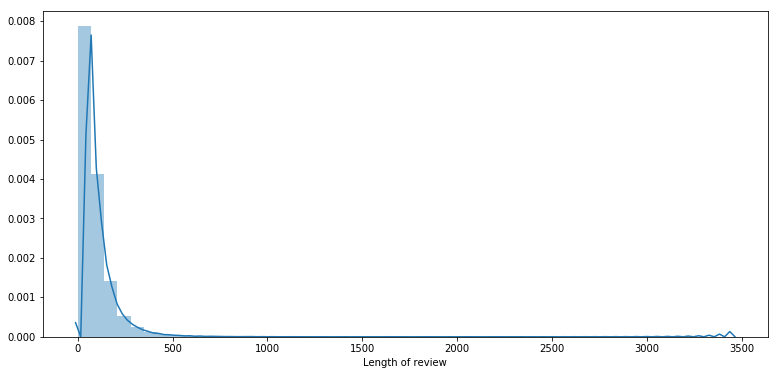

In [98]:
import warnings
warnings.filterwarnings('ignore')

temp = []
for i in range(254915):
    temp.append(len(X_train.examples[i].Text))
plt.figure(figsize=(13,6),)
plt.xlabel('Length of review')
sns.distplot(temp);

In [99]:
temp = 0
for i in range(len(X_train)):
    if(X_train.examples[i].Sentiment == '0'):
        temp += 1 
print('Train:\n negative review examples {0:.2f}%\n positive review examples {1:.2f}%'.format(temp/len(X_train)*100,100-(temp/len(X_train)*100)))
    

Train:
 negative review examples 15.68%
 positive review examples 84.32%


In [100]:
temp = 0
for i in range(len(X_test)):
    if(X_test.examples[i].Sentiment == '0'):
        temp += 1 
print('Test:\n negative examples {0:.2f}%\n positive examples {1:.2f}%'.format(temp/len(X_test)*100,100-(temp/len(X_test)*100)))
    

Test:
 negative examples 15.68%
 positive examples 84.32%


In [101]:
# create one hot encoding features for word.
# here we choose top 30000 most occuring word and all other as <unk>.

max_vacab_size = 30000
Text.build_vocab(X_train,max_size = max_vacab_size)
Label.build_vocab(X_train)

print(f"Unique tokens in TEXT vocabulary: {len(Text.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(Label.vocab)}")

Unique tokens in TEXT vocabulary: 30002
Unique tokens in LABEL vocabulary: 2


**Note**  : here vocabulary size is x+2 but given size is x . one is for `<unk>` for unknown vocabulary word. and one for `<pad>` token

In [102]:
# Top 10 frequently occuering words in vocab
print(Text.vocab.freqs.most_common(10))

[('.', 1053871), ('the', 803142), (',', 754751), ('i', 715497), ('and', 573217), ('a', 532765), ('it', 474108), ('to', 446698), (' ', 440275), ('of', 348509)]


In [103]:
# Vocabulary integer to string [0,1....9]
Text.vocab.itos[:10]

['<unk>', '<pad>', '.', 'the', ',', 'i', 'and', 'a', 'it', 'to']

In [104]:
# Vocabulary string to integer
Text.vocab.stoi['the']

3

In [105]:
# It returns dictionary type object
Label.vocab.stoi

# Note : here '0' is negative and '1' is positive

defaultdict(<function torchtext.vocab._default_unk_index>, {'0': 1, '1': 0})

In [0]:
batch_size = 32

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader,test_loader = data.BucketIterator.splits(datasets=(X_train,X_test),
                                               batch_size=batch_size,
                                               sort_key=lambda x: len(x.Text),#function it should use to group the data.
                                               sort_within_batch=False,
                                               device=device )

In [0]:
# Build the Model
import torch.nn as nn

class RNNmodel(nn.Module):
    def __init__(self,input_dim,embedding_dim,hidden_dim,layer_dim,output_dim):
        super(RNNmodel,self).__init__()
        
        self.embedding = nn.Embedding(input_dim,embedding_dim)
        self.rnn = nn.LSTM(embedding_dim,hidden_dim,layer_dim,dropout=0.5)
        self.fc = nn.Linear(hidden_dim,output_dim)
    def forward(self,text):
        #text = [sentence len, batch size]
        embedded = self.embedding(text)
        #embedded = [sentence len, batch size, emb dim]
        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        # Note output[-1,:,:] == hidden.squeeze(0) for single hidden layer RNN
        return self.fc(output[-1,:,:])

In [0]:
input_dim = len(Text.vocab)
embedding_dim = 100
hidden_dim = 200
layer_dim = 1
output_dim = 1

model = RNNmodel(input_dim,embedding_dim,hidden_dim,layer_dim,output_dim)

In [128]:
def count_parameters(model):
# p.numel() count number of elements in tensor
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Parameters in model: ',count_parameters(model))


Parameters in model:  3242001


In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
criterion = nn.BCEWithLogitsLoss()
# BCEwithLogitsloss = (sigmoid + log loss or binary cross entropy )

In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.Text).squeeze(1)
        loss = criterion(predictions, batch.Sentiment)
        acc = binary_accuracy(predictions, batch.Sentiment)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.Text).squeeze(1)
            loss = criterion(predictions, batch.Sentiment)
            acc = binary_accuracy(predictions, batch.Sentiment)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [136]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 4m 18s
	Train Loss: 0.435 | Train Acc: 84.31%
	 Val. Loss: 0.430 |  Val. Acc: 84.32%
Epoch: 02 | Epoch Time: 4m 18s
	Train Loss: 0.223 | Train Acc: 91.34%
	 Val. Loss: 0.150 |  Val. Acc: 94.31%
Epoch: 03 | Epoch Time: 4m 19s
	Train Loss: 0.116 | Train Acc: 95.56%
	 Val. Loss: 0.130 |  Val. Acc: 94.95%
Epoch: 04 | Epoch Time: 4m 18s
	Train Loss: 0.087 | Train Acc: 96.79%
	 Val. Loss: 0.124 |  Val. Acc: 95.26%
Epoch: 05 | Epoch Time: 4m 18s
	Train Loss: 0.064 | Train Acc: 97.70%
	 Val. Loss: 0.132 |  Val. Acc: 95.18%


If RNN not working awesome! Thank god you atleast got hint of bug!! figure it out.
(sometime RNN work with Error, its too dangerous situation).
Some debugging tips :
* Check for any typos.
* Check for different learning rate
* Check for if any statement condition missing.
* Check for input data pattern and its preprocessing pipelines.

In [0]:
# !pip install spacy

In [138]:
# Code if want to check sentiment of single query review

import spacy
nlp = spacy.load('en')

sentence = "your bag is so fake . plz dont make red version of it"

doc = nlp.tokenizer(sentence.lower())
#print(type(doc))
tokens = [token.text for token in doc]
#print(tokens)
tokens_int = [Text.vocab.stoi[token] for token in tokens]
tensor = torch.ones((2,), dtype=torch.int8)
tokens_int = torch.Tensor([tokens_int])
#print(tokens_int.t().shape)
#model input [Text,batch]
pred = torch.sigmoid(model(tokens_int.t().type(torch.LongTensor).cuda()))
out_class = {0:'Positive',1:'Negative'}
print(out_class[torch.round(pred).item()],' Review detected')
print(1-pred.item())

Negative  Review detected
0.15027910470962524


In [0]:
# Stratified Test Train Spilt
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(review_data.Text,review_data.Sentiment,test_size=0.3,
                                                 stratify=review_data.Sentiment,random_state=42)


In [0]:
X_test_pred = []
for text_review in X_test.values:
    sentence = text_review

    doc = nlp.tokenizer(sentence.lower())
    #print(type(doc))
    tokens = [token.text for token in doc]
    #print(tokens)
    tokens_int = [Text.vocab.stoi[token] for token in tokens]
    tensor = torch.ones((2,), dtype=torch.int8)
    tokens_int = torch.Tensor([tokens_int])
    #print(tokens_int.t().shape)
    #model input [Text,batch]
    pred = torch.sigmoid(model(tokens_int.t().type(torch.LongTensor).cuda()))
    #out_class = {0:'Positive',1:'Negative'}
    #print(out_class[torch.round(pred).item()],' Review detected')
    X_test_pred.append(1-pred.item())

In [141]:
X_test_pred = np.array(X_test_pred)
X_test_pred = X_test_pred>0.5
X_test_pred = X_test_pred.astype(int)
print(X_test_pred)

[1 0 1 ... 1 1 1]


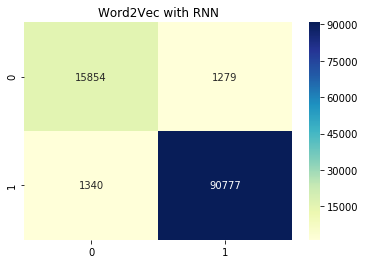

In [142]:
from sklearn.metrics import confusion_matrix

cnf = confusion_matrix(y_test,X_test_pred)
sns.heatmap(cnf,annot=True,fmt='g',cmap="YlGnBu");
plt.title("Word2Vec with RNN");

**Conclusion** : The Word2Vec representation with Recurrent Neural network outperform all the previous models with test accuracy of **95.26%**